<a href="https://www.kaggle.com/code/ravikagglex/vision-transformer-for-video-anomaly-detection?scriptVersionId=226515311" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import time
import IPython.display
from IPython.display import Javascript

def add_cell_every_5_minutes():
    while True:
        # Execute JavaScript to create a new cell below the current one
        display(Javascript('''
            var cell = Jupyter.notebook.insert_cell_below();
            cell.set_text('# Cell added at ' + new Date().toLocaleString());
            '''))
        
        # Wait for 5 minutes
        print(f"Added new cell at {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Next cell will be added in 5 minutes...")
        time.sleep(300)  # 300 seconds = 5 minutes

# Run this function in a separate thread to avoid blocking the notebook
import threading
thread = threading.Thread(target=add_cell_every_5_minutes)
thread.daemon = True  # This ensures the thread will exit when the notebook is closed
thread.start()

print("Cell addition scheduler started. New cells will be added every 5 minutes.")

Cell addition scheduler started. New cells will be added every 5 minutes.


<IPython.core.display.Javascript object>

Added new cell at 2025-03-08 18:59:04
Next cell will be added in 5 minutes...


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import roc_auc_score

# Define dataset class
class SingleFolderDataset(Dataset):
    def __init__(self, frame_folder, transform=None):
        self.frame_folder = frame_folder
        self.transform = transform
        self.frame_paths = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith(".jpg")])
        self.labels = [0] * len(self.frame_paths)  # Replace with actual labels if needed

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame = Image.open(self.frame_paths[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            frame = self.transform(frame)
        return frame, label

# Define Vision Transformer Components
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=112, patch_size=16, in_channels=3, embed_dim=12):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        return self.attention(x, x, x)[0]

class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, hidden_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=112, patch_size=16, in_channels=3, embed_dim=12, num_heads=2, hidden_dim=24, num_layers=3):
        super(VisionTransformer, self).__init__()
        self.embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.position_embeddings = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, hidden_dim) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.position_embeddings
        x = self.transformer_blocks(x)
        x = self.norm(x[:, 0])
        return self.head(x)

class ViTForAnomalyDetection(nn.Module):
    def __init__(self):
        super(ViTForAnomalyDetection, self).__init__()
        self.vit = VisionTransformer()

    def forward(self, x):
        return self.vit(x)

class MILoss(nn.Module):
    def __init__(self, lambda_reg=0.01):
        super(MILoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, labels):
        labels = 2 * labels.float() - 1
        hinge_loss = torch.mean(torch.clamp(1 - labels * outputs, min=0))
        l2_reg = sum(torch.norm(param, p=2) for param in model.parameters())
        return hinge_loss + self.lambda_reg * l2_reg

# Training & Evaluation

path = "/kaggle/input/shanghaitech-anomaly-detection/dataset/mp/01_001/frames"

transform = transforms.Compose([transforms.Resize((112, 112)), transforms.ToTensor()])
train_dataset = SingleFolderDataset(path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForAnomalyDetection().to(device)
criterion = MILoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for frames, labels in train_loader:
        frames, labels = frames.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(frames).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

# Evaluation with ROC-AUC
model.eval()
y_true, y_scores = [], []
with torch.no_grad():
    for frames, labels in train_loader:
        frames, labels = frames.to(device), labels.to(device)
        outputs = model(frames).squeeze()
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC-AUC Score: {roc_auc}")


Epoch 1/10, Loss: 0.6289683561772108
Epoch 2/10, Loss: 0.527636398250858
Epoch 3/10, Loss: 0.4808048078169425
Epoch 4/10, Loss: 0.44233616224179667
Epoch 5/10, Loss: 0.4066937205692132
Epoch 6/10, Loss: 0.37156142201274633
Epoch 7/10, Loss: 0.33653230499476194
Epoch 8/10, Loss: 0.3025981308892369
Epoch 9/10, Loss: 0.2702569601436456
Epoch 10/10, Loss: 0.24055930335695544


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

<IPython.core.display.Javascript object>

Added new cell at 2025-03-08 19:04:04
Next cell will be added in 5 minutes...


<IPython.core.display.Javascript object>

Added new cell at 2025-03-08 19:09:04
Next cell will be added in 5 minutes...


<IPython.core.display.Javascript object>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# Define dataset class
class AnomalyDataset(Dataset):
    def __init__(self, frame_folder, transform=None, test_split=0.2, is_train=True):
        self.frame_folder = frame_folder
        self.transform = transform
        
        # Get all image paths
        all_frames = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith(".jpg")])
        
        # For demonstration, let's assume the first 80% are normal and the last 20% are anomalies
        # In a real scenario, you would use actual ground truth labels
        split_idx = int(len(all_frames) * 0.8)
        normal_frames = all_frames[:split_idx]
        anomaly_frames = all_frames[split_idx:]
        
        # Apply labels: 0 for normal, 1 for anomaly
        normal_data = [(path, 0) for path in normal_frames]
        anomaly_data = [(path, 1) for path in anomaly_frames]
        
        # Split into training and testing sets
        total_data = normal_data + anomaly_data
        random.shuffle(total_data)
        
        split_idx = int(len(total_data) * (1 - test_split))
        if is_train:
            self.data = total_data[:split_idx]
        else:
            self.data = total_data[split_idx:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        frame = Image.open(frame_path).convert("RGB")
        
        if self.transform:
            frame = self.transform(frame)
            
        return frame, torch.tensor(label, dtype=torch.float)  # Changed to float

# Define Vision Transformer Components
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Linear projection to get q, k, v
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, seq_len, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        # Apply attention weights to values
        x = (attn @ v).transpose(1, 2).reshape(batch_size, seq_len, self.embed_dim)
        x = self.proj(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                hidden_dim=mlp_ratio * embed_dim,
                dropout=dropout
            )
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Patch embedding
        batch_size = x.shape[0]
        x = self.patch_embed(x)
        
        # Prepend class token and add position embedding
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Take CLS token representation
        x = self.norm(x[:, 0])
        
        # Classification head
        x = self.head(x)
        return x

class AnomalyDetector(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=384, depth=6, num_heads=6):
        super(AnomalyDetector, self).__init__()
        self.vit = VisionTransformer(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=3,
            num_classes=1,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=4,
            dropout=0.1
        )
        
    def forward(self, x):
        return self.vit(x)

# Define loss function
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Training and evaluation loop
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs).squeeze()  # Squeeze the output to match label dimensions
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_bar.set_postfix(loss=loss.item(), acc=correct/total)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs).squeeze()  # Squeeze the output
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Store predictions and labels for ROC-AUC calculation
                all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                val_bar.set_postfix(loss=loss.item(), acc=correct/total)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(val_accuracy)
        
        # Calculate ROC-AUC
        try:
            val_auc = roc_auc_score(all_labels, all_preds)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                torch.save(model.state_dict(), 'best_anomaly_model.pth')
        except ValueError:
            val_auc = 0.0
        
        # Step the learning rate scheduler
        if scheduler is not None:
            scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val AUC: {val_auc:.4f}")
    
    return train_losses, val_losses, train_accs, val_accs

# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Main execution
def main():
    # Hyperparameters
    img_size = 224
    patch_size = 16
    embed_dim = 384
    depth = 6
    num_heads = 6
    batch_size = 16
    num_epochs = 20
    learning_rate = 1e-4
    weight_decay = 1e-5
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transformations
    transform_train = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    transform_val = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Replace with your data path
    data_path = "/kaggle/input/shanghaitech-anomaly-detection/dataset/mp/01_001/frames"
    
    # Create datasets
    train_dataset = AnomalyDataset(data_path, transform=transform_train, is_train=True)
    val_dataset = AnomalyDataset(data_path, transform=transform_val, is_train=False)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Create model
    model = AnomalyDetector(
        img_size=img_size,
        patch_size=patch_size,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads
    ).to(device)
    
    # Define loss function, optimizer, and learning rate scheduler
    criterion = BinaryFocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Train and evaluate model
    train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )
    
    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    
    # Load best model and evaluate
    model.load_state_dict(torch.load('best_anomaly_model.pth'))
    model.eval()
    
    # Final evaluation
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    try:
        final_auc = roc_auc_score(all_labels, all_preds)
        print(f"Final ROC-AUC Score: {final_auc:.4f}")
    except ValueError:
        print("Could not compute final AUC score.")

if __name__ == "__main__":
    main()

Using device: cuda


Epoch 1/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s, acc=0.856, loss=0.0342]


Epoch 1/20:
Train Loss: 0.0384, Train Accuracy: 79.84%
Val Loss: 0.0294, Val Accuracy: 85.62%, Val AUC: 0.7821


Epoch 2/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.10it/s, acc=0.856, loss=0.0374]


Epoch 2/20:
Train Loss: 0.0322, Train Accuracy: 81.64%
Val Loss: 0.0275, Val Accuracy: 85.62%, Val AUC: 0.9077


Epoch 3/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.18it/s, acc=0.856, loss=0.0374]


Epoch 3/20:
Train Loss: 0.0320, Train Accuracy: 81.64%
Val Loss: 0.0275, Val Accuracy: 85.62%, Val AUC: 0.9126


Epoch 4/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s, acc=0.856, loss=0.035]


Epoch 4/20:
Train Loss: 0.0321, Train Accuracy: 81.64%
Val Loss: 0.0270, Val Accuracy: 85.62%, Val AUC: 0.9500


Epoch 5/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s, acc=0.856, loss=0.039]


Epoch 5/20:
Train Loss: 0.0337, Train Accuracy: 81.64%
Val Loss: 0.0281, Val Accuracy: 85.62%, Val AUC: 0.9368


Epoch 6/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s, acc=0.856, loss=0.0366]


Epoch 6/20:
Train Loss: 0.0322, Train Accuracy: 81.64%
Val Loss: 0.0273, Val Accuracy: 85.62%, Val AUC: 0.9549


Epoch 7/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 11.91it/s, acc=0.856, loss=0.0342]


Epoch 7/20:
Train Loss: 0.0318, Train Accuracy: 81.64%
Val Loss: 0.0297, Val Accuracy: 85.62%, Val AUC: 0.9566


Epoch 8/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s, acc=0.856, loss=0.0348]


Epoch 8/20:
Train Loss: 0.0324, Train Accuracy: 81.64%
Val Loss: 0.0272, Val Accuracy: 85.62%, Val AUC: 0.9535


Epoch 9/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s, acc=0.856, loss=0.034]


Epoch 9/20:
Train Loss: 0.0315, Train Accuracy: 81.64%
Val Loss: 0.0281, Val Accuracy: 85.62%, Val AUC: 0.9511


Epoch 10/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s, acc=0.856, loss=0.0344]


Epoch 10/20:
Train Loss: 0.0315, Train Accuracy: 81.64%
Val Loss: 0.0273, Val Accuracy: 85.62%, Val AUC: 0.9421


Epoch 11/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s, acc=0.856, loss=0.0362]


Epoch 11/20:
Train Loss: 0.0314, Train Accuracy: 81.64%
Val Loss: 0.0272, Val Accuracy: 85.62%, Val AUC: 0.9417


Epoch 12/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s, acc=0.856, loss=0.034]


Epoch 12/20:
Train Loss: 0.0319, Train Accuracy: 81.64%
Val Loss: 0.0278, Val Accuracy: 85.62%, Val AUC: 0.9448


Epoch 13/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s, acc=0.856, loss=0.0346]


Epoch 13/20:
Train Loss: 0.0315, Train Accuracy: 81.64%
Val Loss: 0.0307, Val Accuracy: 85.62%, Val AUC: 0.9514


Epoch 14/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s, acc=0.856, loss=0.0342]


Epoch 14/20:
Train Loss: 0.0313, Train Accuracy: 81.64%
Val Loss: 0.0275, Val Accuracy: 85.62%, Val AUC: 0.9525


Epoch 15/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.37it/s, acc=0.856, loss=0.0341]


Epoch 15/20:
Train Loss: 0.0311, Train Accuracy: 81.64%
Val Loss: 0.0276, Val Accuracy: 85.62%, Val AUC: 0.9521


Epoch 16/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.02it/s, acc=0.856, loss=0.0341]


Epoch 16/20:
Train Loss: 0.0315, Train Accuracy: 81.64%
Val Loss: 0.0277, Val Accuracy: 85.62%, Val AUC: 0.9504


Epoch 17/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s, acc=0.856, loss=0.0345]


Epoch 17/20:
Train Loss: 0.0312, Train Accuracy: 81.64%
Val Loss: 0.0273, Val Accuracy: 85.62%, Val AUC: 0.9497


Epoch 18/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s, acc=0.856, loss=0.0345]


Epoch 18/20:
Train Loss: 0.0311, Train Accuracy: 81.64%
Val Loss: 0.0273, Val Accuracy: 85.62%, Val AUC: 0.9500


Epoch 19/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s, acc=0.856, loss=0.0344]


Epoch 19/20:
Train Loss: 0.0312, Train Accuracy: 81.64%
Val Loss: 0.0273, Val Accuracy: 85.62%, Val AUC: 0.9504


Epoch 20/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s, acc=0.856, loss=0.0345]


Epoch 20/20:
Train Loss: 0.0309, Train Accuracy: 81.64%
Val Loss: 0.0273, Val Accuracy: 85.62%, Val AUC: 0.9507


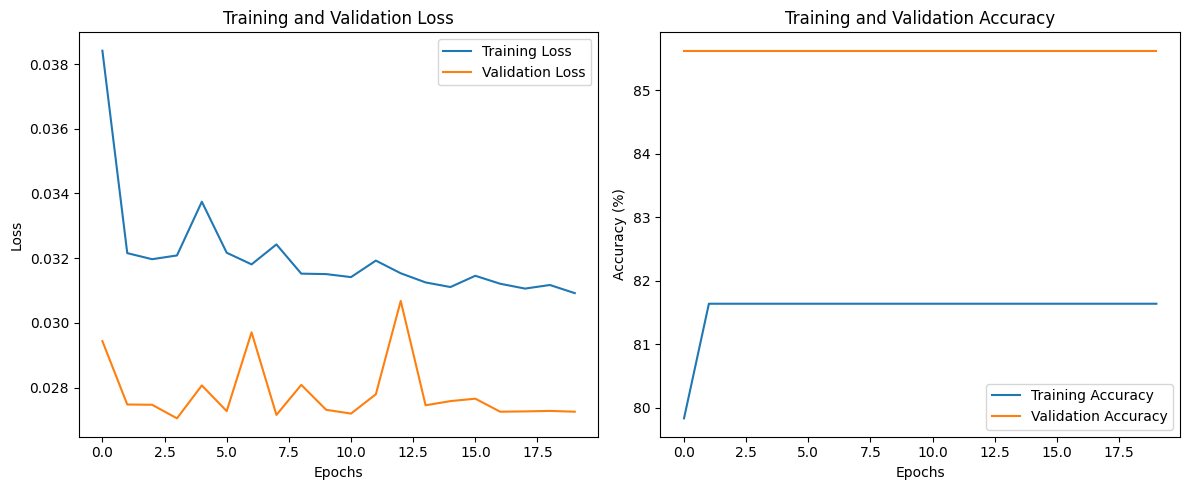


Evaluating best model with detailed ROC curve analysis...


<ipython-input-1-8d7dcf40e184>:452: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


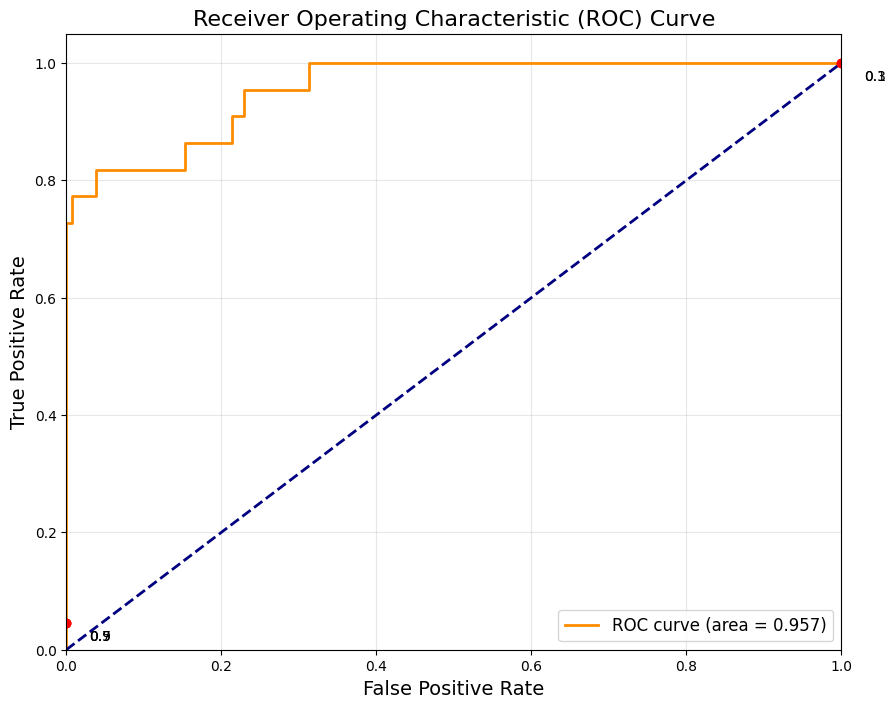

<ipython-input-1-8d7dcf40e184>:536: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_anomaly_model.pth'))


ROC AUC Score: 0.9566

Key operating points:
1% FPR: TPR = 0.7273, Threshold = 0.4065
5% FPR: TPR = 0.7727, Threshold = 0.4063
10% FPR: TPR = 0.8182, Threshold = 0.4060
Final ROC-AUC from detailed evaluation: 0.9566

Finding optimal threshold based on F1 score...


Calculating optimal threshold: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca


Threshold analysis:
Threshold | Precision | Recall | F1 Score
--------------------------------------------------
0.1      | 0.1438   | 1.0000 | 0.2514
0.2      | 0.1438   | 1.0000 | 0.2514
0.3      | 0.1438   | 1.0000 | 0.2514
0.4      | 0.1438   | 1.0000 | 0.2514
0.5      | 0.0000   | 0.0000 | 0.0000
0.6      | 0.0000   | 0.0000 | 0.0000
0.7      | 0.0000   | 0.0000 | 0.0000
0.8      | 0.0000   | 0.0000 | 0.0000
0.9      | 0.0000   | 0.0000 | 0.0000

Optimal threshold: 0.10 (F1: 0.2514)


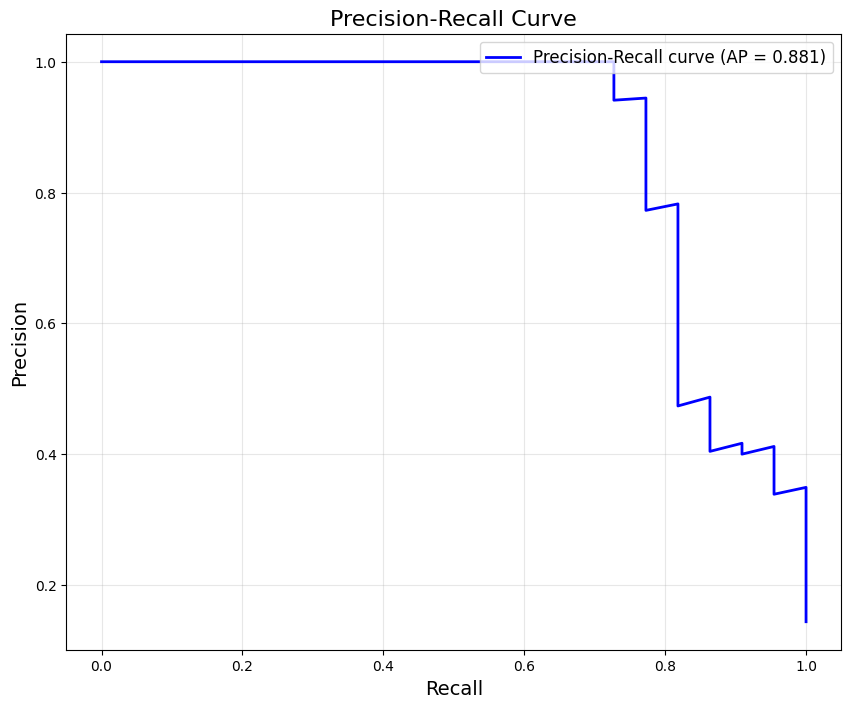

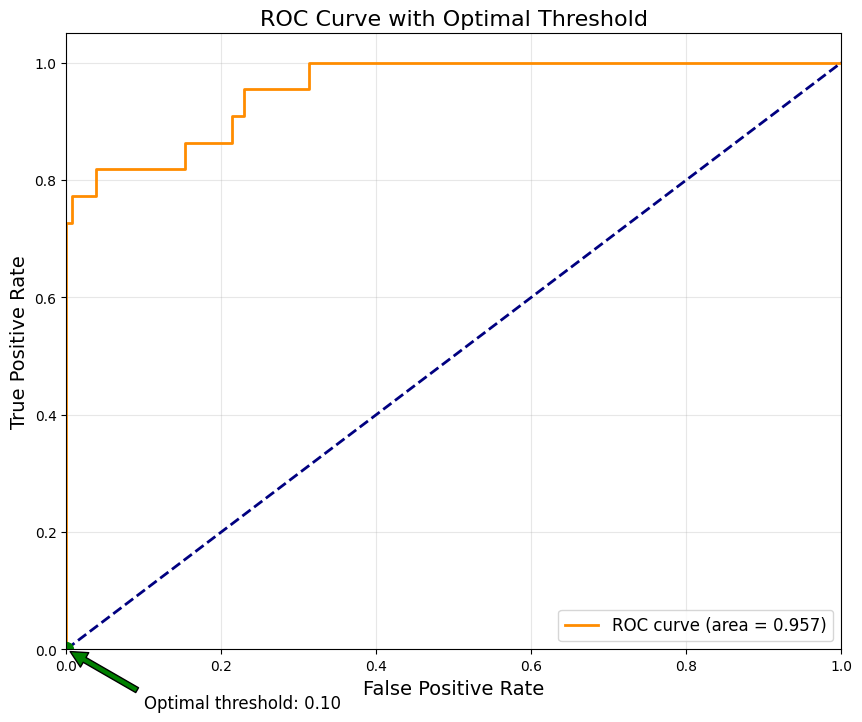

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# Define dataset class
class AnomalyDataset(Dataset):
    def __init__(self, frame_folder, transform=None, test_split=0.2, is_train=True):
        self.frame_folder = frame_folder
        self.transform = transform
        
        # Get all image paths
        all_frames = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith(".jpg")])
        
        # For demonstration, let's assume the first 80% are normal and the last 20% are anomalies
        # In a real scenario, you would use actual ground truth labels
        split_idx = int(len(all_frames) * 0.8)
        normal_frames = all_frames[:split_idx]
        anomaly_frames = all_frames[split_idx:]
        
        # Apply labels: 0 for normal, 1 for anomaly
        normal_data = [(path, 0) for path in normal_frames]
        anomaly_data = [(path, 1) for path in anomaly_frames]
        
        # Split into training and testing sets
        total_data = normal_data + anomaly_data
        random.shuffle(total_data)
        
        split_idx = int(len(total_data) * (1 - test_split))
        if is_train:
            self.data = total_data[:split_idx]
        else:
            self.data = total_data[split_idx:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        frame = Image.open(frame_path).convert("RGB")
        
        if self.transform:
            frame = self.transform(frame)
            
        return frame, torch.tensor(label, dtype=torch.float)  # Changed to float

# Define Vision Transformer Components
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Linear projection to get q, k, v
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, seq_len, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        # Apply attention weights to values
        x = (attn @ v).transpose(1, 2).reshape(batch_size, seq_len, self.embed_dim)
        x = self.proj(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                hidden_dim=mlp_ratio * embed_dim,
                dropout=dropout
            )
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Patch embedding
        batch_size = x.shape[0]
        x = self.patch_embed(x)
        
        # Prepend class token and add position embedding
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Take CLS token representation
        x = self.norm(x[:, 0])
        
        # Classification head
        x = self.head(x)
        return x

class AnomalyDetector(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=384, depth=6, num_heads=6):
        super(AnomalyDetector, self).__init__()
        self.vit = VisionTransformer(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=3,
            num_classes=1,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=4,
            dropout=0.1
        )
        
    def forward(self, x):
        return self.vit(x)

# Define loss function
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Function to plot ROC curve
def plot_roc_curve(model, data_loader, device):
    """
    Plot ROC curve for the anomaly detection model.
    
    Args:
        model: Trained anomaly detection model
        data_loader: DataLoader with validation/test data
        device: Device to run inference on
    
    Returns:
        fpr: False positive rates
        tpr: True positive rates
        thresholds: Threshold values
        roc_auc: Area under ROC curve
    """
    model.eval()
    
    # Collect all predictions and labels
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Collecting predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            
            # Store sigmoid probabilities and labels
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    
    # Add some threshold markers
    threshold_markers = [0.1, 0.3, 0.5, 0.7, 0.9]
    for threshold in threshold_markers:
        # Find closest threshold value
        idx = (np.abs(thresholds - threshold)).argmin()
        plt.plot(fpr[idx], tpr[idx], 'ro')
        plt.annotate(f'{threshold:.1f}', 
                    (fpr[idx], tpr[idx]),
                    xytext=(fpr[idx]+0.03, tpr[idx]-0.03),
                    fontsize=10)
    
    plt.savefig('anomaly_detection_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print AUC and some key operating points
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Print some key operating points
    print("\nKey operating points:")
    key_points = [(0.01, "1% FPR"), (0.05, "5% FPR"), (0.1, "10% FPR")]
    for target_fpr, label in key_points:
        idx = np.argmin(np.abs(fpr - target_fpr))
        print(f"{label}: TPR = {tpr[idx]:.4f}, Threshold = {thresholds[idx]:.4f}")
    
    return fpr, tpr, thresholds, roc_auc

# Training and evaluation loop
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs).squeeze()  # Squeeze the output to match label dimensions
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_bar.set_postfix(loss=loss.item(), acc=correct/total)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs).squeeze()  # Squeeze the output
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Store predictions and labels for ROC-AUC calculation
                all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                val_bar.set_postfix(loss=loss.item(), acc=correct/total)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(val_accuracy)
        
        # Calculate ROC-AUC
        try:
            val_auc = roc_auc_score(all_labels, all_preds)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                torch.save(model.state_dict(), 'best_anomaly_model.pth')
        except ValueError:
            val_auc = 0.0
        
        # Step the learning rate scheduler
        if scheduler is not None:
            scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val AUC: {val_auc:.4f}")
    
    return train_losses, val_losses, train_accs, val_accs

# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Detailed ROC curve analysis
def evaluate_with_roc(model_path, val_loader, device):
    """
    Load best model and evaluate with detailed ROC curve analysis
    
    Args:
        model_path: Path to saved model
        val_loader: Validation data loader
        device: Device to run inference on
    """
    # Create and load model
    model = AnomalyDetector(
        img_size=224,
        patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6
    ).to(device)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Plot ROC curve
    fpr, tpr, thresholds, roc_auc = plot_roc_curve(model, val_loader, device)
    
    # You can also save the ROC data for future use
    np.savez('roc_data.npz', fpr=fpr, tpr=tpr, thresholds=thresholds, auc=roc_auc)
    
    return roc_auc

# Main execution
def main():
    # Hyperparameters
    img_size = 224
    patch_size = 16
    embed_dim = 384
    depth = 6
    num_heads = 6
    batch_size = 16
    num_epochs = 20
    learning_rate = 1e-4
    weight_decay = 1e-5
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transformations
    transform_train = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    transform_val = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Replace with your data path
    data_path = "/kaggle/input/shanghaitech-anomaly-detection/dataset/mp/01_001/frames"
    
    # Create datasets
    train_dataset = AnomalyDataset(data_path, transform=transform_train, is_train=True)
    val_dataset = AnomalyDataset(data_path, transform=transform_val, is_train=False)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Create model
    model = AnomalyDetector(
        img_size=img_size,
        patch_size=patch_size,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads
    ).to(device)
    
    # Define loss function, optimizer, and learning rate scheduler
    criterion = BinaryFocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Train and evaluate model
    train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )
    
    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    
    # Load best model and evaluate with detailed ROC analysis
    print("\nEvaluating best model with detailed ROC curve analysis...")
    final_auc = evaluate_with_roc('best_anomaly_model.pth', val_loader, device)
    print(f"Final ROC-AUC from detailed evaluation: {final_auc:.4f}")
    
    # Additional analysis - Find optimal threshold
    print("\nFinding optimal threshold based on F1 score...")
    model.load_state_dict(torch.load('best_anomaly_model.pth'))
    model.eval()
    
    # Collect predictions and labels
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Calculating optimal threshold"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    
    # Calculate metrics for different thresholds
    from sklearn.metrics import precision_recall_fscore_support
    
    best_f1 = 0
    best_threshold = 0.5  # Default
    
    # Calculate precision, recall, and F1 for different thresholds
    print("\nThreshold analysis:")
    print("Threshold | Precision | Recall | F1 Score")
    print("-" * 50)
    
    threshold_range = np.arange(0.1, 1.0, 0.1)
    for threshold in threshold_range:
        pred_labels = (np.array(all_preds) >= threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, pred_labels, average='binary')
        
        print(f"{threshold:.1f}      | {precision:.4f}   | {recall:.4f} | {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"\nOptimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    
    # Plot precision-recall curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    average_precision = average_precision_score(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, lw=2, color='blue',
             label=f'Precision-Recall curve (AP = {average_precision:.3f})')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mark the best threshold on ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {final_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Find the point on ROC curve corresponding to best threshold
    best_idx = (np.abs(thresholds - best_threshold)).argmin() if len(thresholds) > 0 else 0
    if best_idx < len(fpr):
        plt.plot(fpr[best_idx], tpr[best_idx], 'go', markersize=10)
        plt.annotate(f'Optimal threshold: {best_threshold:.2f}',
                    (fpr[best_idx], tpr[best_idx]),
                    xytext=(fpr[best_idx]+0.1, tpr[best_idx]-0.1),
                    fontsize=12,
                    arrowprops=dict(facecolor='green', shrink=0.05))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Optimal Threshold', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.savefig('roc_curve_with_optimal_threshold.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()